In [1]:
import pandas as pd

df = pd.read_csv("pokemon2.csv", index_col=0)
df.head()

,Name,Type1,Type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Legendary
#,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,0
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,0
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,0
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,0
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,0


In [2]:
df.shape

(800, 11)

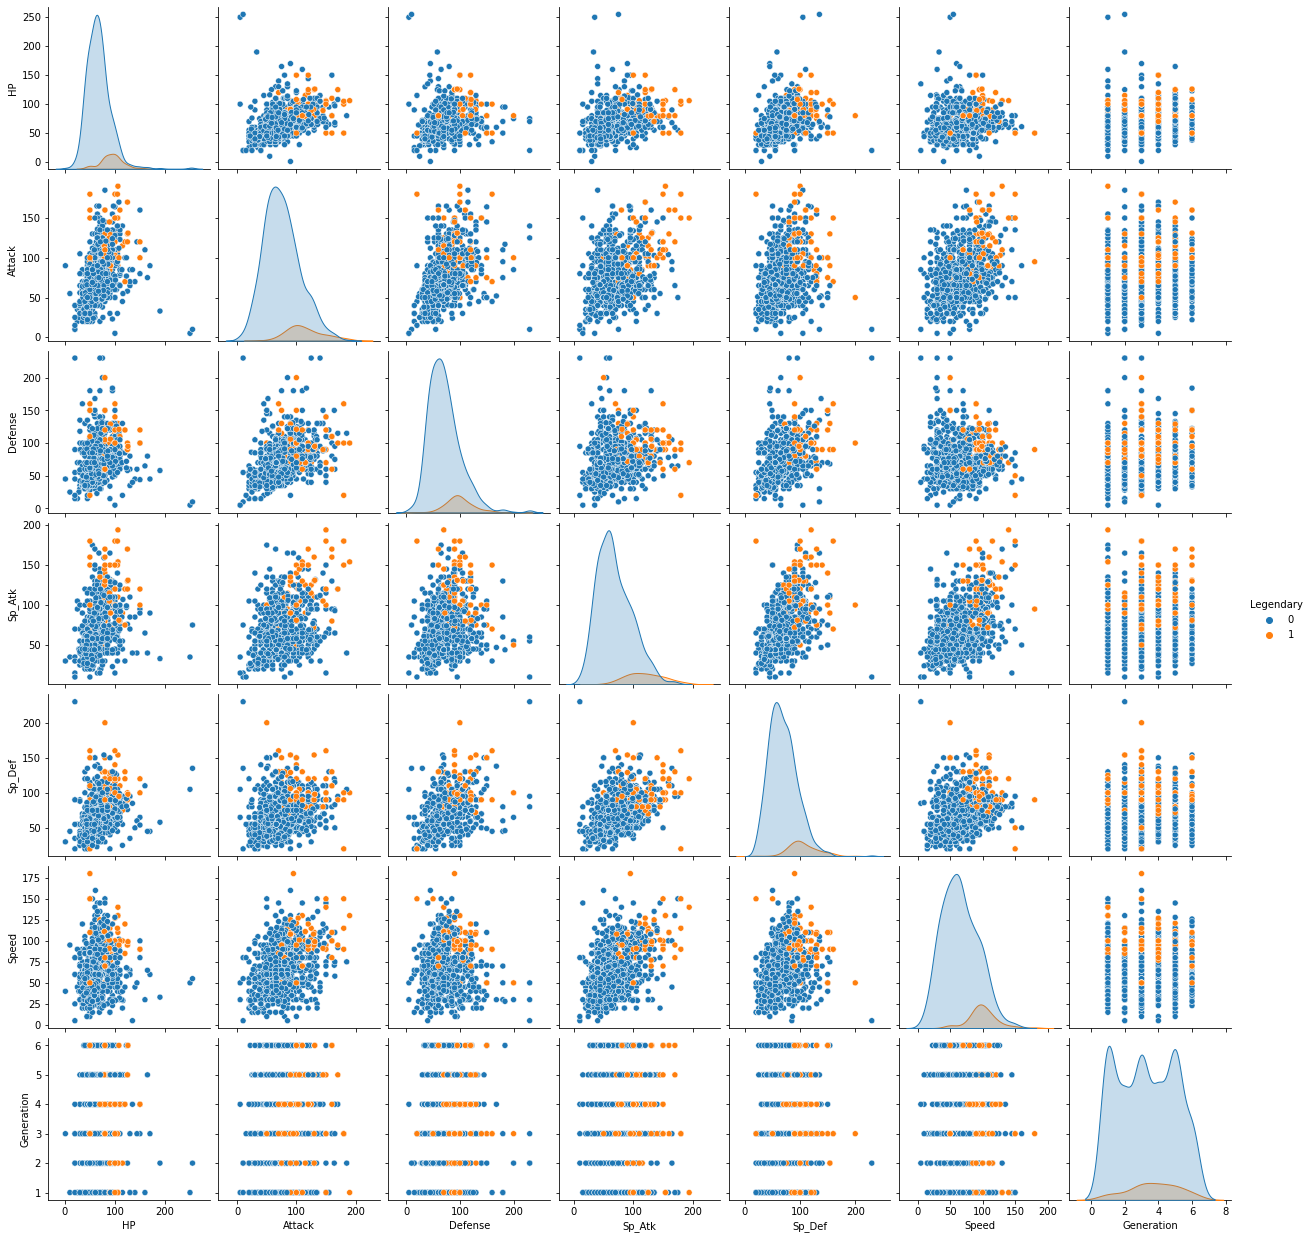

In [3]:
import seaborn as sns

sns.pairplot(df, hue="Legendary")

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

model = make_pipeline(StandardScaler(), LogisticRegression())

In [5]:
from sklearn.model_selection import train_test_split

target = "Legendary"
X, y = df.drop(columns=target).select_dtypes("number"), df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0
)

In [6]:
from sklearn.metrics import balanced_accuracy_score

y_pred = model.fit(X_train, y_train).predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.791385406621665

In [7]:
model.score(X_test, y_test)

0.96

<AxesSubplot:>

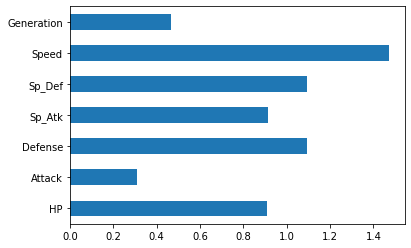

In [8]:
coefs = pd.Series(model[-1].coef_[0], index=X_train.columns)
coefs.plot.barh()

In [9]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=0)
scoring = ["accuracy", "balanced_accuracy"]
cv_results = cross_validate(
    model, X, y, cv=cv, scoring=scoring, return_estimator=True, n_jobs=-1,
)

In [10]:
for score_name in scoring:
    scores = cv_results[f"test_{score_name}"]
    print(f"{score_name}: {scores.mean():.3f} +/- {scores.std():.3f}")

accuracy: 0.939 +/- 0.021
balanced_accuracy: 0.755 +/- 0.092


In [11]:
coefs = pd.DataFrame(
    [model[-1].coef_[0] for model in cv_results["estimator"]],
    columns=X_train.columns
)
coefs

,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation
0,0.959504,0.552703,1.031643,1.019997,1.152539,1.463539,0.496736
1,0.897234,0.492024,1.073841,1.041540,1.052080,1.462130,0.558676
2,0.923234,0.449617,1.056399,1.037929,1.048885,1.402730,0.515356
3,0.992669,0.433704,1.072778,1.028686,0.955434,1.495011,0.585539
4,0.975219,0.426459,1.045672,1.034210,1.063693,1.365953,0.485125
...,...,...,...,...,...,...,...
95,0.944929,0.538516,1.083332,1.083543,1.138251,1.517724,0.503226
96,0.906544,0.509234,1.006922,1.056732,1.155249,1.444517,0.697751
97,0.945913,0.514534,1.068625,1.090103,1.048655,1.442571,0.496006
98,0.874604,0.505639,0.954870,0.983376,1.275015,1.441968,0.468061


<AxesSubplot:>

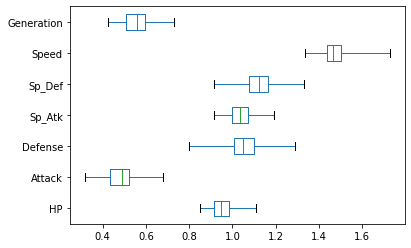

In [12]:
coefs.plot.box(whis=100, vert=False)

In [13]:
X = df.drop(columns=[target, "Name"])

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 800
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Type1       800 non-null    object
 1   Type2       414 non-null    object
 2   HP          800 non-null    int64 
 3   Attack      800 non-null    int64 
 4   Defense     800 non-null    int64 
 5   Sp_Atk      800 non-null    int64 
 6   Sp_Def      800 non-null    int64 
 7   Speed       800 non-null    int64 
 8   Generation  800 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 62.5+ KB


In [15]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numerical_preprocessor = StandardScaler()
categorical_preprocessor = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing", add_indicator=True),
    OneHotEncoder(handle_unknown="ignore")
)
preprocessor = make_column_transformer(
    (numerical_preprocessor, selector(dtype_exclude=object)),
    (categorical_preprocessor, selector(dtype_include=object))
)
model = make_pipeline(preprocessor, LogisticRegression())

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=0)
scoring = ["accuracy", "balanced_accuracy"]
cv_results = cross_validate(
    model, X, y, cv=cv, scoring=scoring, return_estimator=True, n_jobs=-1,
)

In [17]:
for score_name in scoring:
    scores = cv_results[f"test_{score_name}"]
    print(f"{score_name}: {scores.mean():.3f} +/- {scores.std():.3f}")

accuracy: 0.948 +/- 0.022
balanced_accuracy: 0.801 +/- 0.086


In [18]:
names = (
    selector(dtype_include="number")(X) +
    (cv_results["estimator"][0][0].named_transformers_["pipeline"][-1]
                                  .get_feature_names(
                                      input_features=["Type1",
                                                      "Type2",
                                                      "MissingIndicator"])).tolist()
)

names

['HP',
 'Attack',
 'Defense',
 'Sp_Atk',
 'Sp_Def',
 'Speed',
 'Generation',
 'Type1_Bug',
 'Type1_Dark',
 'Type1_Dragon',
 'Type1_Electric',
 'Type1_Fairy',
 'Type1_Fighting',
 'Type1_Fire',
 'Type1_Flying',
 'Type1_Ghost',
 'Type1_Grass',
 'Type1_Ground',
 'Type1_Ice',
 'Type1_Normal',
 'Type1_Poison',
 'Type1_Psychic',
 'Type1_Rock',
 'Type1_Steel',
 'Type1_Water',
 'Type2_Bug',
 'Type2_Dark',
 'Type2_Dragon',
 'Type2_Electric',
 'Type2_Fairy',
 'Type2_Fighting',
 'Type2_Fire',
 'Type2_Flying',
 'Type2_Ghost',
 'Type2_Grass',
 'Type2_Ground',
 'Type2_Ice',
 'Type2_Normal',
 'Type2_Poison',
 'Type2_Psychic',
 'Type2_Rock',
 'Type2_Steel',
 'Type2_Water',
 'Type2_missing',
 'MissingIndicator_False',
 'MissingIndicator_True']

In [19]:
coefs = pd.DataFrame(
    [model[-1].coef_[0] for model in cv_results["estimator"]],
    columns=names
)
coefs

,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Type1_Bug,Type1_Dark,Type1_Dragon,...,Type2_Ice,Type2_Normal,Type2_Poison,Type2_Psychic,Type2_Rock,Type2_Steel,Type2_Water,Type2_missing,MissingIndicator_False,MissingIndicator_True
0,1.198631,0.683334,1.114462,1.070088,1.275543,1.497446,0.652940,-0.592828,-0.493496,-0.068001,...,0.076259,-0.106594,-0.201370,0.126276,-0.046911,-0.058590,0.329012,0.390873,-0.391338,0.390873
1,1.209321,0.601610,1.220222,1.112978,1.138874,1.524365,0.742763,-0.430900,-0.279029,-0.206366,...,0.078575,-0.082472,-0.293657,0.198544,-0.049674,0.114907,0.323455,0.410891,-0.410880,0.410891
2,1.188176,0.630377,1.229459,1.100410,1.162107,1.446205,0.721297,-0.536450,-0.200368,-0.405904,...,0.156670,-0.107329,-0.281239,0.050228,-0.044419,0.038024,0.306345,0.430543,-0.430263,0.430543
3,1.237569,0.574870,1.219915,1.110250,1.040542,1.499024,0.707321,-0.544513,-0.282159,-0.422026,...,0.070543,-0.063580,-0.329893,0.391359,-0.047769,-0.068186,0.281612,0.343111,-0.343465,0.343111
4,1.219815,0.549044,1.184744,1.077896,1.129571,1.421307,0.658745,-0.584690,-0.210724,-0.074329,...,0.064112,-0.114545,-0.334800,-0.022804,-0.048818,0.011602,0.317115,0.376371,-0.376815,0.376371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.193633,0.660641,1.233016,1.137708,1.218543,1.519889,0.700491,-0.593084,-0.293370,0.030979,...,0.014144,-0.099905,-0.218842,0.106220,-0.036532,-0.031832,0.326959,0.397140,-0.396681,0.397140
96,1.174887,0.652270,1.083139,1.100026,1.272387,1.476192,0.964435,-0.466563,-0.235963,0.116291,...,0.047352,-0.132288,-0.132108,0.181972,-0.034913,-0.013104,0.340484,0.499696,-0.499442,0.499696
97,1.191372,0.605723,1.199044,1.133639,1.125085,1.493483,0.629684,-0.566115,-0.404205,-0.333841,...,-0.120079,-0.118855,-0.389464,0.333586,-0.050294,-0.043080,0.314322,0.375018,-0.374724,0.375018
98,1.110694,0.691139,1.073596,0.964791,1.356701,1.404629,0.655535,-0.601230,-0.121868,-0.133540,...,0.090583,-0.084673,-0.326395,0.303792,-0.050098,0.075873,-0.112400,0.351587,-0.351837,0.351587


<AxesSubplot:>

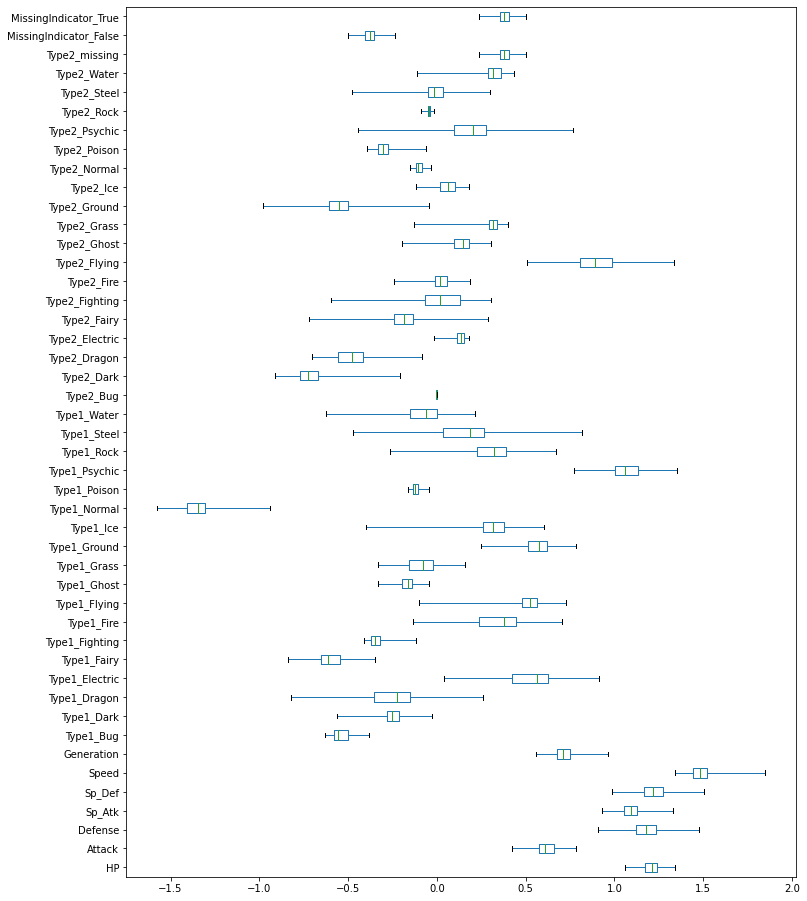

In [20]:
coefs.plot.box(whis=100, vert=False, figsize=(12, 16))